In [69]:
# System packages
import os
import re
import sys
import warnings
# Data related
import numpy as np 
import pandas as pd 

# sklearn  
from sklearn.metrics import  accuracy_score
from sklearn.model_selection import train_test_split, cross_val_predict,cross_val_score,  StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
from tensorflow.keras import backend

In [65]:
# Add utils_functions.py as a dataset
from shutil import copyfile

# Copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/utils-functions/utils_functions.py", dst = '/kaggle/working/utils_functions.py')
from utils_functions import *

## 0 Preprocessing

In [ ]:
# Train data for training and validation
df_train = pd.read_csv('train_variants_text.csv') 
train = df_process(df_train)
train['data_type']='train'
print('train data size:',len(train))

In [ ]:
# Test data for submission
df_test = pd.read_csv('stage2_test_variants_text.csv') 
test = df_process(df_test)
test['data_type']='test'
print('test data size:',len(test))

### Combine both train and test data => all_data

In [ ]:
all_data = pd.concat([train, test], sort=False)
all_data['Text']=all_data['Text'].apply(textClean_full)
print('all_data size:',len(all_data))
all_data.to_csv('pm_all_data_clean_class_20190614.csv', index= False)   

## 1 Load preprocessed all_data 

In [14]:
all_data= pd.read_csv('/Users/j/Dropbox/Learn/health_precisionmedicine/data/processed/pm_all_data_clean_class_20190614.csv')
all_data.head(1)

,ID,Gene,Variation,Text,data_type,Class
0,0,FAM58A,Truncating Mutations,cyclin dependent kinases cdks regulate variety...,train,1.0


### Group Variantions 

In [408]:
df = group_Variation(df)

In [411]:
groupby_col_size(df,'Variation').head(100)

Variation
snv_other               3812
fusions                  197
truncating mutations     112
del                       95
amplification             77
overexpression             6
promoter                   3
dtype: int64

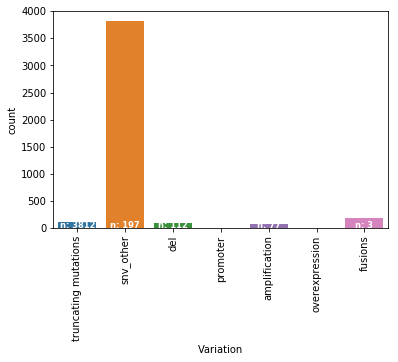

In [412]:
fig =col_count_plot(df, 'Variation')

## 2. Label Encoding train.Class

In [ ]:
train_y  = label_encoder(train_size)


## 3 Build Doc2Vec model

In [414]:
sentences = constructLabeledSentences(all_data,'Text')
#sentences[0]

In [416]:
text_input_dim =300
train_size = 3316
test_size=986

In [417]:
text_model = get_doc2vec_model(sentences, '../input/pm-model-doc2vec-all/doc2vec_all_20190614.d2v',text_input_dim=text_input_dim)

Found ../input/pm-model-doc2vec-all/doc2vec_all_20190614.d2v


## 4. Featurize Text for train and test data

In [419]:
text_train_arrays, text_test_arrays = build_text_array(text_model, \
                                                       text_input_dim,\
                                                       train_size,\
                                                       test_size)

In [420]:
print(text_train_arrays.shape)
print(text_test_arrays.shape)

(3316, 300)
(986, 300)


In [421]:
print(text_train_arrays[0][:10])

[ 0.49902058 -0.21902579  0.23566465  0.6866526  -0.76406091 -0.47411516
 -0.10866016  0.80849326  0.36930278  0.03643488]


## 5 Feature Gene and Variation 

In [422]:
# Dimension reduction
from sklearn.decomposition import TruncatedSVD
gene_dim=25
variation_dim=5

# Pipeline for Gene
Gene = Pipeline([
    ('selector',ItemSelector(key="Gene")),
    #('converter',Converter()),
    ('onehot',OneHotEncoder()),
    ('tsvd',TruncatedSVD(n_components=gene_dim, n_iter=gene_dim, random_state=12))
])

# Pipeline for Variation
Variation = Pipeline([
    ('selector',ItemSelector(key="Variation")),
    #('converter',Converter()),
    ('onehot',OneHotEncoder()),
    ('tsvd',TruncatedSVD(n_components=variation_dim, n_iter=variation_dim, random_state=12))
])

In [423]:
Gene_vector = Gene.fit_transform(all_data)
print(Gene_vector.shape)


(4302, 25)


In [424]:
Variation_vector = Variation.fit_transform(all_data)
print(Variation_vector.shape)


(4302, 5)


## 5.1 Stack 3 features 

In [426]:
train_set, test_set = stack_3_features(Gene_vector, \
                         Variation_vector,\
                         train_size,\
                         text_train_arrays, \
                         text_test_arrays)

In [427]:
print(train_set.shape)
print(test_set.shape)
#print(train_set[0][:10])
input_shape=train_set.shape[1]
print(input_shape)

(3316, 330)
(986, 330)
330


### Training

In [431]:
# Import KerasRegressor model
from keras.wrappers.scikit_learn import KerasRegressor
clf = KerasRegressor(build_fn=baseline_model)

In [432]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
# Build estimator
def build_estimator(clf,train_set, train_y, epochs,verbose):
    # split data 
    X_train, X_validation, y_train, y_validation = train_test_split(train_set, train_y, test_size=0.33, stratify=train_y, shuffle= True, random_state=42)
    # Save best model 
    weightsname = '{}{:%Y%m%dT%H%M%S}.hd5'.format(('doc2vec_keras'), datetime.datetime.now())
    checkpointer = ModelCheckpoint(filepath=weightsname, verbose=verbose, save_best_only=True)
    # Build estimator   
    estimator=clf.fit(X_train, y_train, batch_size=32, epochs=epochs, callbacks=[checkpointer],validation_data=(X_validation, y_validation))
    #estimator=clf.fit(train_set, train_y, validation_split=0.33, epochs=epochs, batch_size=32)
    return estimator

In [433]:
estimator1=build_estimator(clf,train_set, train_y, epochs=50,verbose=1)

Train on 2221 samples, validate on 1095 samples
Epoch 1/50
2221/2221 [==============================] - 1s 253us/step - loss: 2.0372 - acc: 0.2774 - val_loss: 1.8935 - val_acc: 0.2868

Epoch 00001: val_loss improved from inf to 1.89354, saving model to doc2vec_keras20190616T141412.hd5
Epoch 2/50
2221/2221 [==============================] - 0s 83us/step - loss: 1.8351 - acc: 0.3062 - val_loss: 1.7505 - val_acc: 0.3342

Epoch 00002: val_loss improved from 1.89354 to 1.75046, saving model to doc2vec_keras20190616T141412.hd5
Epoch 3/50
2221/2221 [==============================] - 0s 85us/step - loss: 1.6596 - acc: 0.3809 - val_loss: 1.5682 - val_acc: 0.4210

Epoch 00003: val_loss improved from 1.75046 to 1.56820, saving model to doc2vec_keras20190616T141412.hd5
Epoch 4/50
2221/2221 [==============================] - 0s 72us/step - loss: 1.5755 - acc: 0.4214 - val_loss: 1.5089 - val_acc: 0.4548

Epoch 00004: val_loss improved from 1.56820 to 1.50887, saving model to doc2vec_keras20190616T14

### Inspect training results

In [435]:
train_history= save_history_df(estimator1)
print('The best epoch is ')
print(train_history.loc[train_history['val_acc'] == train_history.val_acc.max()])


The best epoch is 
       val_loss  val_acc      loss       acc
epoch                                       
43     1.197349  0.63105  0.911486  0.654660
45     1.155238  0.63105  0.906939  0.647456


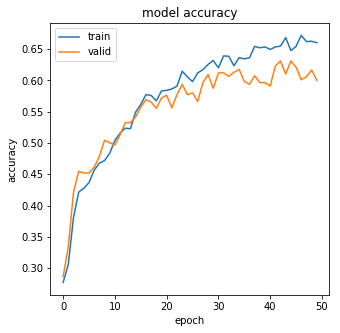

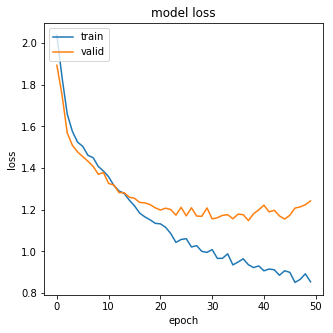

In [458]:
plot_history(estimator1)

### 5.2 How about stack 2 features? 

In [439]:
train_set, test_set = stack_2_features(Variation_vector,\
                         train_size,\
                         text_train_arrays, \
                         text_test_arrays)

In [440]:
print(train_set.shape)
print(test_set.shape)
#print(train_set[0][:10])
input_shape=train_set.shape[1]
print(input_shape)

(3316, 305)
(986, 305)
305


In [441]:
estimator2=build_estimator(clf,train_set, train_y, epochs=50,verbose=1)

Train on 2221 samples, validate on 1095 samples
Epoch 1/50
2221/2221 [==============================] - 1s 258us/step - loss: 2.0297 - acc: 0.2697 - val_loss: 1.8907 - val_acc: 0.2868

Epoch 00001: val_loss improved from inf to 1.89074, saving model to doc2vec_keras20190616T141437.hd5
Epoch 2/50
2221/2221 [==============================] - 0s 85us/step - loss: 1.8514 - acc: 0.2873 - val_loss: 1.8142 - val_acc: 0.2868

Epoch 00002: val_loss improved from 1.89074 to 1.81418, saving model to doc2vec_keras20190616T141437.hd5
Epoch 3/50
2221/2221 [==============================] - 0s 87us/step - loss: 1.7584 - acc: 0.3327 - val_loss: 1.6505 - val_acc: 0.4046

Epoch 00003: val_loss improved from 1.81418 to 1.65048, saving model to doc2vec_keras20190616T141437.hd5
Epoch 4/50
2221/2221 [==============================] - 0s 89us/step - loss: 1.6130 - acc: 0.4160 - val_loss: 1.5575 - val_acc: 0.4210

Epoch 00004: val_loss improved from 1.65048 to 1.55753, saving model to doc2vec_keras20190616T14

In [442]:
train_history= save_history_df(estimator2)
print('The best epoch is ')
print(train_history.loc[train_history['val_acc'] == train_history.val_acc.max()])


The best epoch is 
       val_loss   val_acc      loss       acc
epoch                                        
49     1.297033  0.594521  0.938192  0.640702
50     1.278650  0.594521  0.938592  0.640702


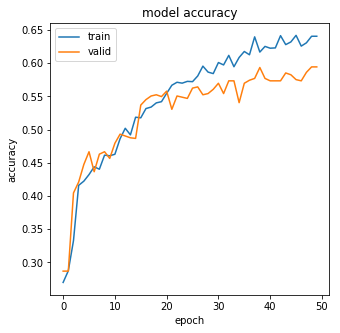

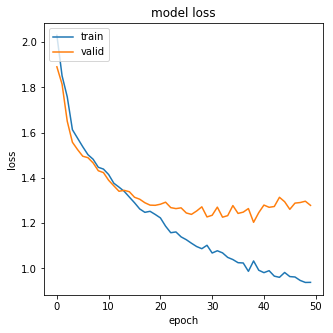

In [443]:
plot_history(estimator2)

### 5.3 How about just Text feature?

In [444]:
train_set, test_set = (text_train_arrays, \
                         text_test_arrays)

In [445]:
print(train_set.shape)
print(test_set.shape)
#print(train_set[0][:10])
input_shape=train_set.shape[1]
print(input_shape)

(3316, 300)
(986, 300)
300


In [446]:
estimator3=build_estimator(clf,train_set, train_y, epochs=50,verbose=1)

Train on 2221 samples, validate on 1095 samples
Epoch 1/50
2221/2221 [==============================] - 1s 289us/step - loss: 2.0198 - acc: 0.2747 - val_loss: 1.8698 - val_acc: 0.2868

Epoch 00001: val_loss improved from inf to 1.86980, saving model to doc2vec_keras20190616T141617.hd5
Epoch 2/50
2221/2221 [==============================] - 0s 78us/step - loss: 1.8382 - acc: 0.2985 - val_loss: 1.7795 - val_acc: 0.3260

Epoch 00002: val_loss improved from 1.86980 to 1.77950, saving model to doc2vec_keras20190616T141617.hd5
Epoch 3/50
2221/2221 [==============================] - 0s 91us/step - loss: 1.6953 - acc: 0.3624 - val_loss: 1.5713 - val_acc: 0.4164

Epoch 00003: val_loss improved from 1.77950 to 1.57128, saving model to doc2vec_keras20190616T141617.hd5
Epoch 4/50
2221/2221 [==============================] - 0s 93us/step - loss: 1.5989 - acc: 0.4084 - val_loss: 1.5278 - val_acc: 0.4247

Epoch 00004: val_loss improved from 1.57128 to 1.52784, saving model to doc2vec_keras20190616T14

2221/2221 [==============================] - 0s 67us/step - loss: 1.0280 - acc: 0.6128 - val_loss: 1.2978 - val_acc: 0.5562

Epoch 00038: val_loss did not improve from 1.25663
Epoch 39/50
2221/2221 [==============================] - 0s 68us/step - loss: 1.0314 - acc: 0.6042 - val_loss: 1.2913 - val_acc: 0.5689

Epoch 00039: val_loss did not improve from 1.25663
Epoch 40/50
2221/2221 [==============================] - 0s 69us/step - loss: 1.0206 - acc: 0.6195 - val_loss: 1.3039 - val_acc: 0.5534

Epoch 00040: val_loss did not improve from 1.25663
Epoch 41/50
2221/2221 [==============================] - 0s 69us/step - loss: 1.0112 - acc: 0.6267 - val_loss: 1.2821 - val_acc: 0.5753

Epoch 00041: val_loss did not improve from 1.25663
Epoch 42/50
2221/2221 [==============================] - 0s 69us/step - loss: 1.0252 - acc: 0.6078 - val_loss: 1.3125 - val_acc: 0.5635

Epoch 00042: val_loss did not improve from 1.25663
Epoch 43/50
2221/2221 [==============================] - 0s 66us/step - 

In [449]:
train_history= save_history_df(estimator3)
print('The best epoch is ')
print(train_history.loc[train_history['val_acc'] == train_history.val_acc.max()])


The best epoch is 
       val_loss   val_acc      loss       acc
epoch                                        
35     1.285297  0.580822  1.057306  0.604683


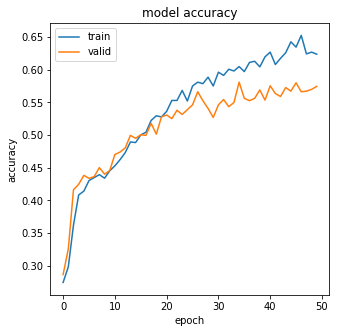

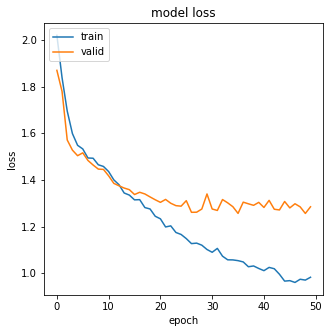

In [450]:
plot_history(estimator3)